# 🧭 Case Study B — Week 1: Tool Router

You're back for round two! This time, you aren't managing meeting tasks; you are building an intelligent routing system that solves a real travel industry challenge: automatically directing booking requests to the right service API.


**Pipeline:**

Once again, you'll walk through the complete Machine Learning Engineer pipeline:

1. 🗂️ **Load the data** — Get your travel booking dataset ready
2. 🔍 **Inspect the dataset** — Understand what you're working with
3. 📊 **Visualize the embeddings** — See your data in 2D space using PCA
4. 🧱 **Define architecture** — Build your model, dataset, and metrics
5. 🏋️ **Train the classifier** — Watch your MLP learn the routing patterns
6. 🎯 **Evaluate performance** — Test how well it routes on unseen data
7. 🚀 **Live routing demo** — Try it yourself with real travel requests!

By the end, you will have trained an MLP classifier that intelligently routes travel plans between the 3 booking classes: flights, hotels, and activities. This is the core intelligence behind agentic travel apps where users describe their dream vacation and the system automatically books everything with a single click.

---
## 1 🗂️ Load the Data

We load pre-computed 384-dim sentence embeddings from CSVs from the `data-generation/` directory. Each row contains an embedding vector (columns `"0"`–`"383"`), a string label (`Flight`, `Hotel`, or `CarRental`), and the original sentence.

In [3]:
# cell to clone the repo for data and demo html on colab
!git clone -b week1/tool-picker/data-generation https://github.com/eth-bmai-fs26/project.git
!git fetch && git checkout week1/tool-picker/data-generation
%cd project/week1/tool-picker

fatal: destination path 'project' already exists and is not an empty directory.
fatal: not a git repository (or any of the parent directories): .git
/content/project/week1/tool-picker


In [4]:
import os, sys

PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), ".."))
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

DATA_DIR = os.path.join(os.getcwd(), "data-generation")

train_path = os.path.join(DATA_DIR, "train.csv")
val_path = os.path.join(DATA_DIR, "val.csv")
test_path = os.path.join(DATA_DIR, "test.csv")

### How did sentences become numbers?

Before training a classifier, we need to turn each sentence into something a model can work with: a list of numbers called an **embedding**.

Our classifier will work by learning to categorize these sentence embeddings rather than the raw text itself.

Think of it like this:

> **"Book a flight to Paris"** → `[0.12, -0.03, 0.47, …, 0.08]` (384 numbers)

A small pretrained language model reads the sentence and compresses its meaning into a fixed-size vector of 384 numbers. Sentences that mean similar things end up with similar vectors. For example, *"Reserve a plane ticket to Rome"* would land close to *"Book a flight to Paris"* in this 384-dimensional space, while *"Find me a hotel downtown"* would be farther away.

You don't need to run this step yourself. It was already done ahead of time, and the CSVs you loaded above contain the resulting embedding vectors.

---
## 2 🔍 Load & Inspect

Read the three CSVs into DataFrames and print shapes, class distribution, and a preview of the first few rows to verify the data looks correct.

In [5]:
import numpy as np
import pandas as pd

LABEL_NAMES = {0: "FLIGHT_BOOKER", 1: "HOTEL_BOOKER", 2: "CAR_RENTAL_BOOKER"}
LABEL_MAP = {"Flight": 0, "Hotel": 1, "CarRental": 2}

train_df = pd.read_csv(train_path, index_col=0)
val_df   = pd.read_csv(val_path,   index_col=0)
test_df  = pd.read_csv(test_path,  index_col=0)

for df in (train_df, val_df, test_df):
    df["label"] = df["label"].map(LABEL_MAP)

print(f"Train shape: {train_df.shape}")
print(f"Val shape:   {val_df.shape}")
print(f"Test shape:  {test_df.shape}")
print(f"\nClass distribution (train):")
print(train_df["label"].value_counts().sort_index().rename(LABEL_NAMES))
train_df.head()

Train shape: (480, 386)
Val shape:   (60, 386)
Test shape:  (60, 386)

Class distribution (train):
label
FLIGHT_BOOKER        163
HOTEL_BOOKER         157
CAR_RENTAL_BOOKER    160
Name: count, dtype: int64


,sentence,label,0,1,2,3,4,5,6,7,...,374,375,376,377,378,379,380,381,382,383
145,Be prepared for flight delays by staying infor...,0,0.011291,-0.086371,-0.075290,0.044167,0.041076,0.012258,-0.001550,-0.042792,...,0.032920,0.021219,0.033290,-0.021752,0.075874,0.048034,-0.018400,-0.020188,-0.129308,0.066606
9,Pick-up was quick and efficient at the airport...,2,0.045309,0.055251,-0.004740,0.064523,0.055696,-0.000915,0.049095,-0.001695,...,0.074264,-0.006875,-0.059607,-0.136500,-0.008050,-0.007518,0.001626,0.045416,-0.097829,0.028200
375,Some car rental companies offer additional ser...,2,-0.045497,-0.025865,0.054861,-0.009555,-0.011061,0.043582,0.032290,0.006642,...,-0.013538,-0.008973,0.031408,-0.070326,0.052605,0.096739,-0.119718,0.003405,0.008353,-0.012864
523,Some hotels may have specific policies for gue...,1,0.079692,0.052289,-0.017164,0.030751,-0.023578,0.059357,0.066963,-0.069361,...,-0.021722,0.046201,0.078260,-0.024286,-0.003114,-0.017408,0.056246,0.065392,-0.001722,-0.012767
188,"One should pack essential travel accessories, ...",0,-0.009893,0.061001,-0.014181,0.009607,0.063567,0.017920,0.069195,0.013902,...,-0.018924,0.007097,-0.016630,0.054531,0.069095,0.031171,-0.093916,0.030913,0.022701,-0.068916


---
## 3 📊 Visualize the embeddings

Project the embeddings down to 2-D with PCA and scatter-plot them colored by class.

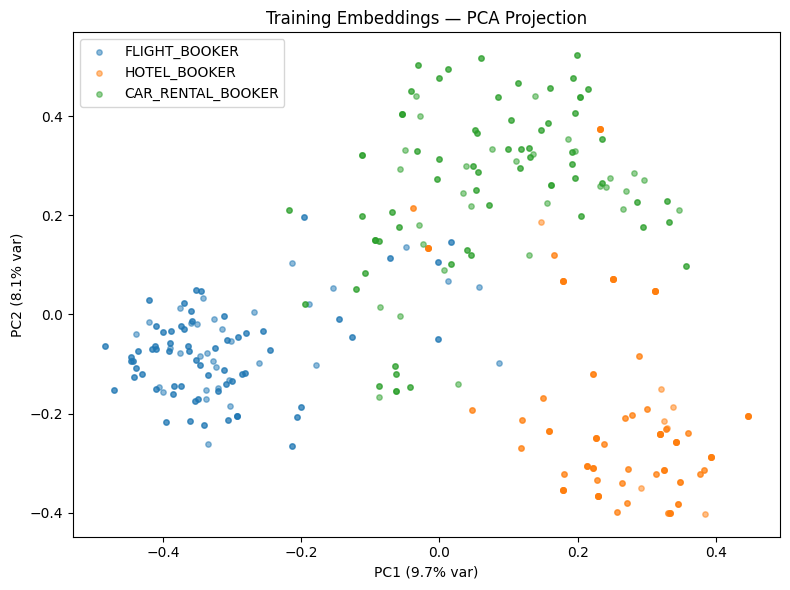

In [6]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

emb_cols = sorted(
    [c for c in train_df.columns if str(c).isdigit()],
    key=lambda c: int(c),
)
X_train = train_df[emb_cols].values
y_train = train_df["label"].values

pca = PCA(n_components=2, random_state=42)
X_2d = pca.fit_transform(X_train)

plt.figure(figsize=(8, 6))
for k in range(3):
    mask = y_train == k
    plt.scatter(X_2d[mask, 0], X_2d[mask, 1], label=LABEL_NAMES[k], alpha=0.5, s=15)

plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]:.1%} var)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]:.1%} var)")
plt.title("Training Embeddings — PCA Projection")
plt.legend()
plt.tight_layout()
plt.show()

---
## 4 🧱 Model, Dataset & Metrics Definitions

### 4.1 🗃️ PyTorch Dataset + DataLoaders

`ToolRouterDataset` reads a CSV, auto-detects embedding columns (numeric column names `0…383`), maps string labels to integers, and returns `(FloatTensor, LongTensor)` pairs. `make_dataloaders` wraps the three splits into shuffled/non-shuffled `DataLoader`s.

In [7]:
import torch
from torch.utils.data import DataLoader, Dataset


class ToolRouterDataset(Dataset):
    """Loads a Tool Router CSV and serves (embedding, label) pairs.

    Embedding columns are identified as purely numeric column names
    (e.g. ``0, 1, ..., 383``).
    """

    def __init__(self, csv_path: str):
        df = pd.read_csv(csv_path, index_col=0)

        emb_cols = sorted(
            [c for c in df.columns if str(c).isdigit()],
            key=lambda c: int(c),
        )
        if len(emb_cols) == 0:
            raise ValueError(f"No embedding columns found in {csv_path}")

        self.embeddings = torch.tensor(df[emb_cols].values, dtype=torch.float32)
        self.labels = torch.tensor(df["label"].map(LABEL_MAP).values, dtype=torch.long)
        self.dim = len(emb_cols)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.embeddings[idx], self.labels[idx]


def make_dataloaders(train_path, val_path, test_path, batch_size=64, num_workers=0):
    """Create train, val, and test DataLoaders from CSV paths."""
    train_ds = ToolRouterDataset(train_path)
    val_ds   = ToolRouterDataset(val_path)
    test_ds  = ToolRouterDataset(test_path)

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True,  num_workers=num_workers)
    val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False, num_workers=num_workers)
    test_loader  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False, num_workers=num_workers)
    return train_loader, val_loader, test_loader


print("✅ Dataset & DataLoader ready.")

✅ Dataset & DataLoader ready.


### 4.2 🧠 MLP Baseline

A minimal two-layer MLP: `Linear(d → hidden) → ReLU → Dropout → Linear(hidden → 3)`. Outputs raw logits (no softmax) so it pairs directly with `CrossEntropyLoss`.

In [8]:
import torch.nn as nn


class ToolRouterMLP(nn.Module):
    """Simple two-layer MLP: Linear → ReLU → Dropout → Linear.

    Outputs raw logits.
    """

    def __init__(self, input_dim, hidden_dim=128, num_classes=3, dropout_p=0.1):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout_p),
            nn.Linear(hidden_dim, num_classes),
        )

    def forward(self, x):
        return self.network(x)


print("✅ ToolRouterMLP ready.")

✅ ToolRouterMLP ready.


### 4.3 📐 Metrics

Two simple evaluation tools: `accuracy` (how many predictions are correct) and `confusion_matrix` (shows which classes get confused with each other).

In [9]:
def accuracy(y_true, y_pred) -> float:
    """Fraction of correct predictions."""
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    return float((y_true == y_pred).sum()) / len(y_true)


def confusion_matrix(y_true, y_pred, num_classes=3) -> np.ndarray:
    """Confusion matrix — rows = true class, columns = predicted class."""
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    cm = np.zeros((num_classes, num_classes), dtype=int)
    for t, p in zip(y_true, y_pred):
        cm[t, p] += 1
    return cm

---
## 5 🏋️ Train the classifier

### 5.1 ⚙️ Hyperparameters & Reproducibility

Set all training hyperparameters in one place and fix random seeds so you get the same results every time you run the code.

In [10]:
import random

SEED       = 42
EPOCHS     = 20
BATCH_SIZE = 64
HIDDEN_DIM = 128
LR         = 1e-3
DROPOUT_P  = 0.1


def set_seed(seed):
    """Set all RNG seeds for reproducibility."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)


set_seed(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🖥️  Device: {device}")

🖥️  Device: cpu


### 5.2 📦 DataLoaders + Model Init

Wrap the three CSVs into PyTorch `DataLoader`s and instantiate the MLP, Adam optimizer, and cross-entropy loss.

In [11]:
train_loader, val_loader, test_loader = make_dataloaders(
    train_path, val_path, test_path,
    batch_size=BATCH_SIZE,
)
input_dim = train_loader.dataset.dim

print(f"Input dim: {input_dim}")
print(f"Train: {len(train_loader.dataset)}  "
      f"Val: {len(val_loader.dataset)}  "
      f"Test: {len(test_loader.dataset)}")

model = ToolRouterMLP(
    input_dim=input_dim,
    hidden_dim=HIDDEN_DIM,
    num_classes=3,
    dropout_p=DROPOUT_P,
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=LR)
loss_fn = nn.CrossEntropyLoss()

print(f"\n{model}")

Input dim: 384
Train: 480  Val: 60  Test: 60

ToolRouterMLP(
  (network): Sequential(
    (0): Linear(in_features=384, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=128, out_features=3, bias=True)
  )
)


### 5.3 🔁 Training Loop

Define `train_one_epoch` and `evaluate` helper functions, then run the full training loop for  `EPOCH` epochs, printing train/val loss and accuracy each epoch.

In [12]:
def train_one_epoch(model, loader, optimizer, loss_fn, device):
    """Train for one epoch. Returns (avg_loss, accuracy)."""
    model.train()
    total_loss = 0.0
    correct = 0
    total = 0

    for x, y in loader:
        x, y = x.to(device), y.to(device)

        logits = model(x)
        assert logits.shape[1] == 3, f"Expected 3 logits, got {logits.shape[1]}"
        loss = loss_fn(logits, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * x.size(0)
        preds = logits.argmax(dim=1)
        correct += (preds == y).sum().item()
        total += x.size(0)

    return total_loss / total, correct / total


def evaluate(model, loader, loss_fn, device):
    """Evaluate on a dataset. Returns (avg_loss, accuracy, y_true, y_pred)."""
    model.eval()
    total_loss = 0.0
    all_true = []
    all_pred = []

    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            logits = model(x)
            loss = loss_fn(logits, y)

            total_loss += loss.item() * x.size(0)
            preds = logits.argmax(dim=1)
            all_true.extend(y.cpu().numpy())
            all_pred.extend(preds.cpu().numpy())

    total = len(all_true)
    acc = accuracy(all_true, all_pred)
    return total_loss / total, acc, all_true, all_pred


# --- run training ---
for epoch in range(1, EPOCHS + 1):
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, loss_fn, device)
    val_loss, val_acc, _, _ = evaluate(model, val_loader, loss_fn, device)
    print(f"Epoch {epoch:2d}/{EPOCHS}  "
          f"train_loss={train_loss:.4f}  train_acc={train_acc:.4f}  "
          f"val_loss={val_loss:.4f}  val_acc={val_acc:.4f}")

Epoch  1/20  train_loss=1.0693  train_acc=0.7208  val_loss=1.0293  val_acc=0.9000
Epoch  2/20  train_loss=0.9825  train_acc=0.9083  val_loss=0.9300  val_acc=0.8833
Epoch  3/20  train_loss=0.8641  train_acc=0.9146  val_loss=0.8068  val_acc=0.8833
Epoch  4/20  train_loss=0.7256  train_acc=0.9187  val_loss=0.6719  val_acc=0.9000
Epoch  5/20  train_loss=0.5817  train_acc=0.9271  val_loss=0.5436  val_acc=0.9000
Epoch  6/20  train_loss=0.4525  train_acc=0.9458  val_loss=0.4385  val_acc=0.9000
Epoch  7/20  train_loss=0.3519  train_acc=0.9479  val_loss=0.3610  val_acc=0.9000
Epoch  8/20  train_loss=0.2787  train_acc=0.9458  val_loss=0.3084  val_acc=0.9167
Epoch  9/20  train_loss=0.2253  train_acc=0.9542  val_loss=0.2721  val_acc=0.9167
Epoch 10/20  train_loss=0.1898  train_acc=0.9625  val_loss=0.2495  val_acc=0.9167
Epoch 11/20  train_loss=0.1669  train_acc=0.9625  val_loss=0.2355  val_acc=0.9167
Epoch 12/20  train_loss=0.1478  train_acc=0.9729  val_loss=0.2191  val_acc=0.9333
Epoch 13/20  tra

---
## 6 🎯 Evaluate performance

Run the trained model on the held-out test split and print overall accuracy plus a confusion matrix (rows = true, cols = predicted).

In [13]:
test_loss, test_acc, y_true, y_pred = evaluate(model, test_loader, loss_fn, device)

print(f"🎯 Test Loss:     {test_loss:.4f}")
print(f"🎯 Test Accuracy: {test_acc:.4f}")

cm = confusion_matrix(y_true, y_pred, num_classes=3)
cm_df = pd.DataFrame(
    cm,
    index=[LABEL_NAMES[i] for i in range(3)],
    columns=[LABEL_NAMES[i] for i in range(3)],
)
print(f"\n📋 Confusion Matrix (rows=true, cols=pred):")
cm_df

🎯 Test Loss:     0.0778
🎯 Test Accuracy: 1.0000

📋 Confusion Matrix (rows=true, cols=pred):


,FLIGHT_BOOKER,HOTEL_BOOKER,CAR_RENTAL_BOOKER
FLIGHT_BOOKER,18,0,0
HOTEL_BOOKER,0,22,0
CAR_RENTAL_BOOKER,0,0,20


### 6.1 🔥 Confusion Matrix Heatmap

Render the confusion matrix as a color-coded heatmap for a quick visual read on where the model confuses classes.

,FLIGHT_BOOKER,HOTEL_BOOKER,CAR_RENTAL_BOOKER
FLIGHT_BOOKER,18,0,0
HOTEL_BOOKER,0,22,0
CAR_RENTAL_BOOKER,0,0,20


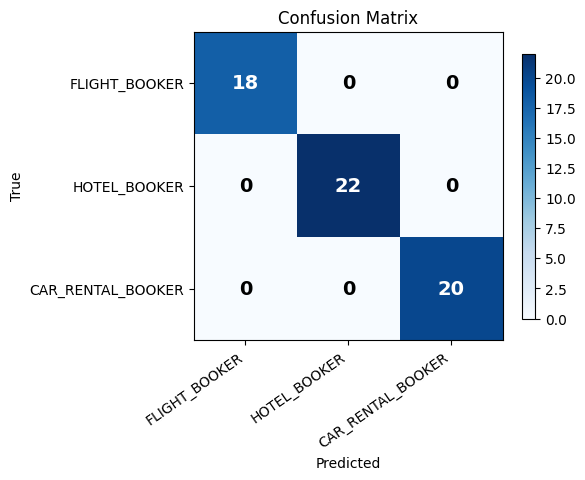

In [14]:
import matplotlib.pyplot as plt

cm_df = pd.DataFrame(
    cm,
    index=[LABEL_NAMES[i] for i in range(3)],
    columns=[LABEL_NAMES[i] for i in range(3)],
)
display(cm_df)

fig, ax = plt.subplots(figsize=(6, 5))
im = ax.imshow(cm, cmap="Blues")

tick_labels = [LABEL_NAMES[i] for i in range(3)]
ax.set_xticks(range(3))
ax.set_yticks(range(3))
ax.set_xticklabels(tick_labels, rotation=35, ha="right")
ax.set_yticklabels(tick_labels)
ax.set_xlabel("Predicted")
ax.set_ylabel("True")
ax.set_title("Confusion Matrix")

for i in range(3):
    for j in range(3):
        ax.text(j, i, str(cm[i, j]), ha="center", va="center",
                color="white" if cm[i, j] > cm.max() / 2 else "black",
                fontsize=14, fontweight="bold")

fig.colorbar(im, ax=ax, shrink=0.8)
plt.tight_layout()
plt.show()

---
## 7 🚀 Try It Yourself — Live Routing Demo

Time to put the model to work! The widget below lets you upload a `.txt` travel plan file. Start by trying the provided `sample_plan.txt`, then create your own custom travel plans! When you click **Route My Plan**, each step in your file is:

1. Parsed from the structured plan format (Plan ID, Trip summary, numbered steps)
2. Embedded into a 384-dim vector (using the same sentence encoder model that produced the training data)
3. Fed through the MLP you just trained
4. Classified as `FLIGHT_BOOKER`, `HOTEL_BOOKER`, or `CAR_RENTAL_BOOKER`

The results appear in a beautiful table showing each step's routing decision with confidence scores!

In [ ]:
from IPython.display import HTML
from google.colab import output
from visualization import parse_plan_text, route_plan_steps

import logging, warnings
warnings.filterwarnings("ignore")
logging.disable(logging.WARNING)

from sentence_transformers import SentenceTransformer
import IPython, json, requests

# Load the same embedding model used during data generation
embedder = SentenceTransformer("all-MiniLM-L6-v2")

# Restore default logging after load
logging.disable(logging.NOTSET)

TOOL_EMOJIS = {
    "FLIGHT_BOOKER": "\u2708\ufe0f",
    "HOTEL_BOOKER": "\U0001f3e8",
    "CAR_RENTAL_BOOKER": "\U0001f697",
}

HTML_PATH = "plan_router_app.html"

def route_plan_file_callback(plan_content: str):
    """Parse and route plan from uploaded file"""
    try:
        plan = parse_plan_text(plan_content)
        if not plan["steps"]:
            return IPython.display.JSON({"error": "No steps found"})
        results = route_plan_steps(plan, model, embedder, device)
        return IPython.display.JSON({
            "plan_id": plan["plan_id"],
            "trip_summary": plan["trip_summary"],
            "results": results
        })
    except Exception as e:
        return IPython.display.JSON({"error": str(e)})

output.register_callback("notebook.RoutePlanFile", route_plan_file_callback)
print("✅ Callback registered")

with open(HTML_PATH, 'r') as f:
    widget_html = f.read()

display(HTML(widget_html))